# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0, )
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
offer_id     32 non-null int64
campaign     32 non-null object
varietal     32 non-null object
min_qty      32 non-null int64
discount     32 non-null int64
origin       32 non-null object
past_peak    32 non-null bool
dtypes: bool(1), int64(3), object(3)
memory usage: 1.7+ KB


In [5]:
df_offers.varietal.value_counts()

Champagne             7
Cabernet Sauvignon    6
Pinot Noir            4
Prosecco              4
Merlot                3
Espumante             3
Chardonnay            2
Malbec                2
Pinot Grigio          1
Name: varietal, dtype: int64

In [6]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
customer_name    324 non-null object
offer_id         324 non-null int64
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


In [7]:
# Outer merge two dataframes on offer_id
df_merged = pd.merge(df_transactions, df_offers[['offer_id']], how='outer', on='offer_id')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 3 columns):
customer_name    324 non-null object
offer_id         324 non-null int64
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 10.1+ KB


In [8]:
df_merged.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Rodriguez,2,1
2,Martin,2,1
3,Jackson,2,1
4,Campbell,2,1


In [9]:
# Create a pivot table where each offer_id forms a column with customer name as index. 
# If a customer responed to a particular offer_id, assign 1, else 0
import numpy as np
df_pivot = pd.pivot_table(df_merged, values='n', index='customer_name',
               columns=['offer_id'], aggfunc=np.sum, fill_value=0)

In [10]:
# Check if 1 and 0 is assigned correctly to indicate whether a cusotmer responded to an offer or not
assert df_pivot.values.sum() == len(df_transactions)

In [11]:
# Convert the pivot table to a dataframe
df_wide = pd.DataFrame(df_pivot.to_records())

# Assert that newly created wide format of dataframe has all the customer names correct
assert df_wide.shape[0] == df_transactions.customer_name.nunique()

df_wide.head()

,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [12]:
# Create numpy matrix of features
x_cols = df_wide.iloc[:, 1:].values

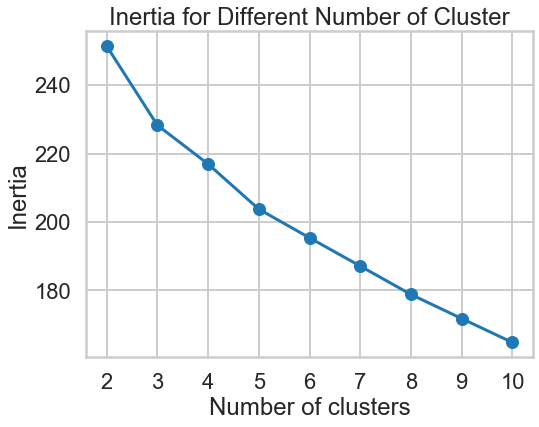

In [13]:
# Try KMeans with K in the range of 2-10 to find the best K. Use Inertia_ to score different Ks.
# Inertia_ is sum of squared distances of samples to their closest cluster center.
from sklearn.cluster import KMeans

error_inertia = []
for i in range(2, 11):
    km = KMeans(n_clusters=i, 
                random_state=42)
    km.fit(x_cols)
    error_inertia.append(km.inertia_)

fig = plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), error_inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(2,11), range(2, 11))
plt.title('Inertia for Different Number of Cluster')
plt.show()

In [14]:
# Calculate % reduction in SS for every increment of K
for i in range(1, len(error_inertia)):
    ss_reduction = ((error_inertia[i - 1] - error_inertia[i])/error_inertia[i - 1]) * 100
    print (f'% reduction in SS from k = {i + 1} to k = {i + 2} is: {round(ss_reduction, 2)}%')

% reduction in SS from k = 2 to k = 3 is: 9.21%
% reduction in SS from k = 3 to k = 4 is: 4.97%
% reduction in SS from k = 4 to k = 5 is: 6.08%
% reduction in SS from k = 5 to k = 6 is: 4.11%
% reduction in SS from k = 6 to k = 7 is: 4.23%
% reduction in SS from k = 7 to k = 8 is: 4.44%
% reduction in SS from k = 8 to k = 9 is: 3.94%
% reduction in SS from k = 9 to k = 10 is: 4.07%


[22 35 17  9 17]


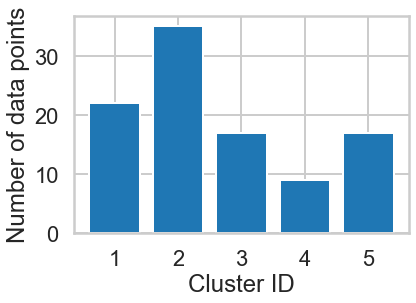

In [15]:
# Bar chart showing the number of data points in each cluster for KMeans with best 𝐾 = 5

km = KMeans(n_clusters=5, random_state=42)
labels = km.fit_predict(x_cols)
print(np.bincount(labels))

plt.bar(range(5), np.bincount(labels))
plt.xticks(range(5), range(1, 6))
plt.xlabel('Cluster ID')
plt.ylabel('Number of data points');

### Exercise Set II: Answers

In general, a predictive model with lower error is better. However, in case of KMeans, the lowest SS can be obtained if we set k = n (number of samples). This is not what we wanted. So we select a K at which SS starts to decrease at a lower rate.

I think, as per the elbow plot above K = 5 is a good pick. The major challenge here is, the rate of reduction in SS from K = 3 to K = 10 for each increment of K is almost identical. In such situation some domain expertise and knowledge about the dataset is necessary for choosing the best value of K.

In the following cell, I have checked if PCA can help in identifying number of clusters. However, as we can see in the following two charts, it is difficult to find a clustering pattern based on two or three principal components.

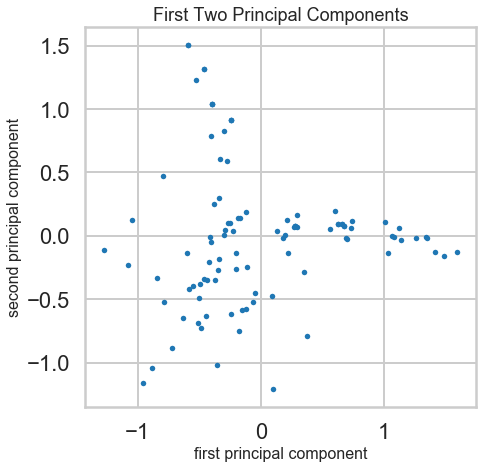

In [16]:
# PCA to get first two principal components
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_cols)
X_pca = pca.transform(x_cols)

# Plot first two principal components
plt.figure(figsize=(7,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], linewidths=0, s=30)
plt.xlabel("first principal component", fontsize=16)
plt.ylabel("second principal component", fontsize=16)
plt.title("First Two Principal Components", fontsize=18);

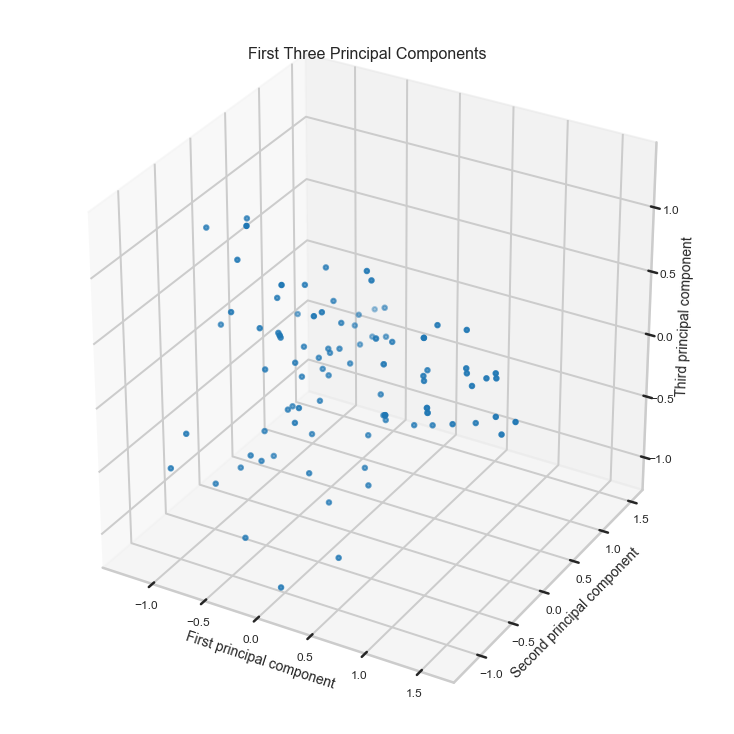

In [17]:
# PCA to get first three principal components
pca = PCA(n_components=3)
pca.fit(x_cols)
X_pca = pca.transform(x_cols)

from mpl_toolkits.mplot3d import Axes3D

# Plot first two principal components
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
ax.set_xlabel("First principal component", fontsize=14)
ax.set_ylabel("Second principal component", fontsize=14)
ax.set_zlabel("Third principal component", fontsize=14)
plt.title("First Three Principal Components", fontsize=16)          
plt.show();

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.094
For n_clusters = 3 The average silhouette_score is : 0.119
For n_clusters = 4 The average silhouette_score is : 0.123
For n_clusters = 5 The average silhouette_score is : 0.141
For n_clusters = 6 The average silhouette_score is : 0.137
For n_clusters = 7 The average silhouette_score is : 0.116
For n_clusters = 8 The average silhouette_score is : 0.113
For n_clusters = 9 The average silhouette_score is : 0.125
For n_clusters = 10 The average silhouette_score is : 0.119


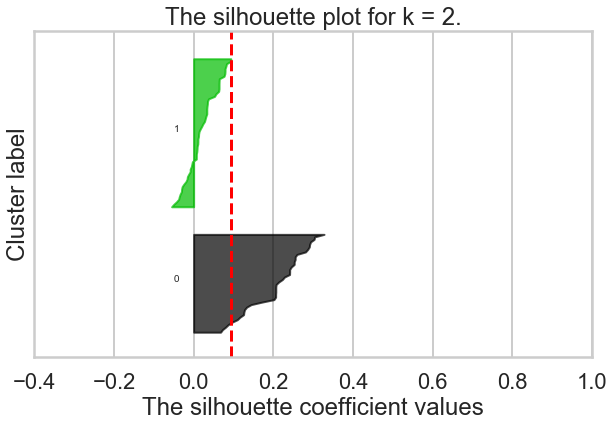

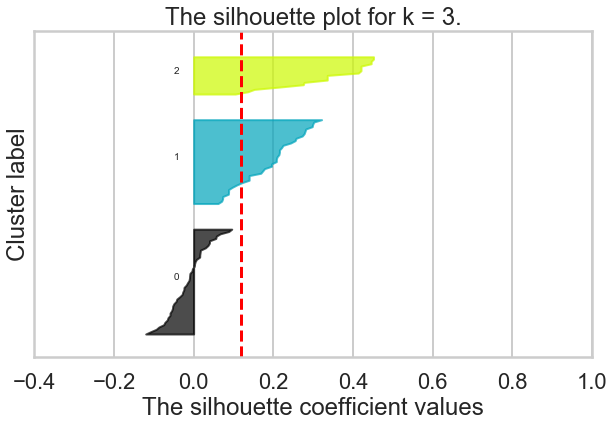

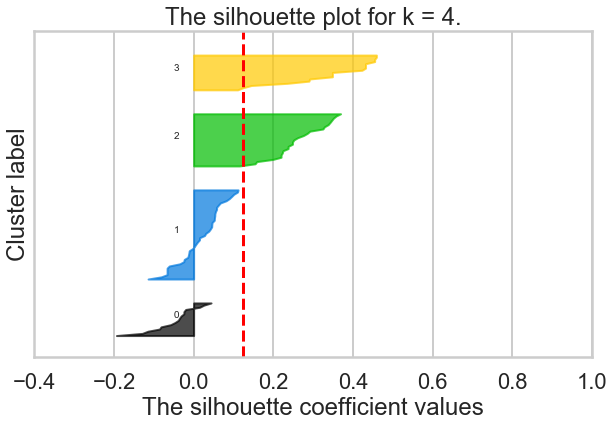

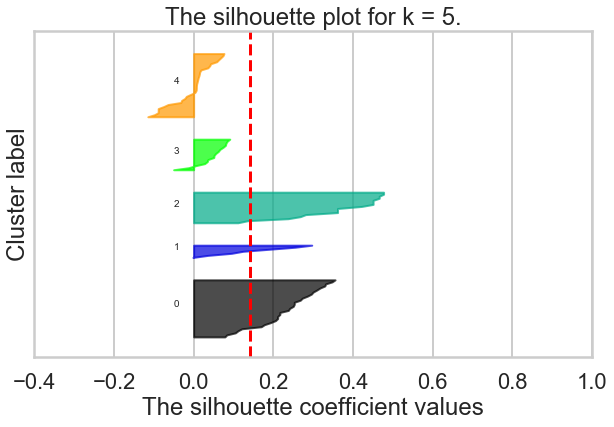

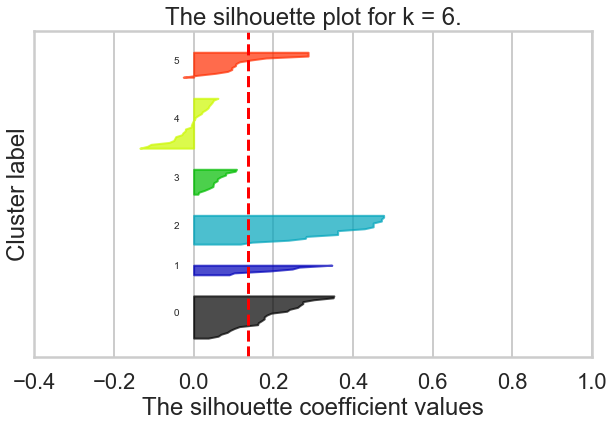

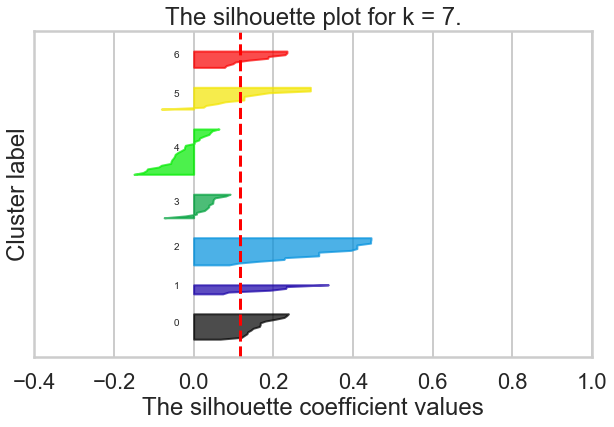

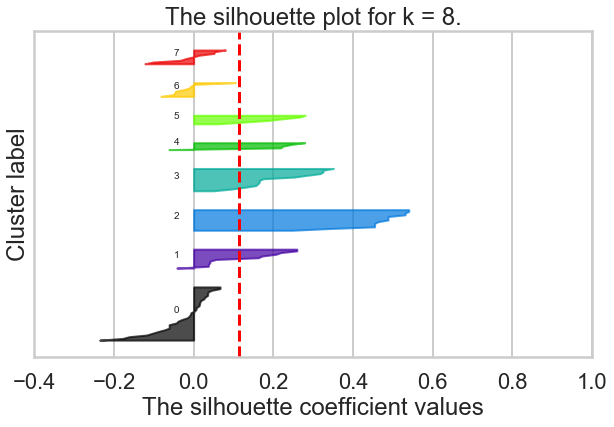

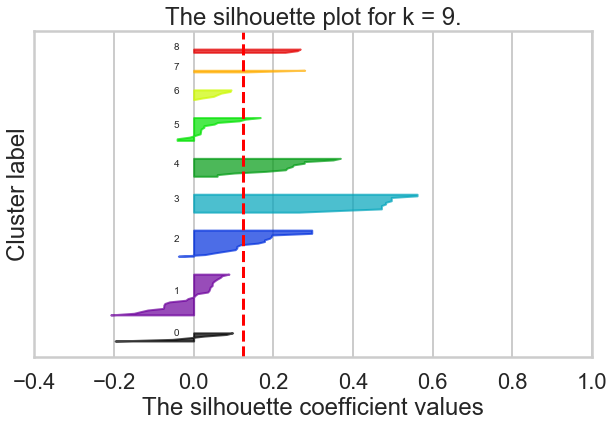

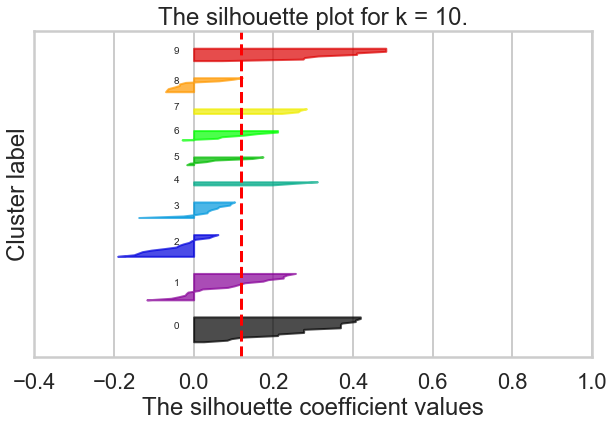

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = list(range(2, 11))
sil_avg = []

for n_clusters in range_n_clusters:
    # Create a subplot 
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)

    # Plot the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.4, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    sil_avg.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg, 3))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f"The silhouette plot for k = {n_clusters}.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()


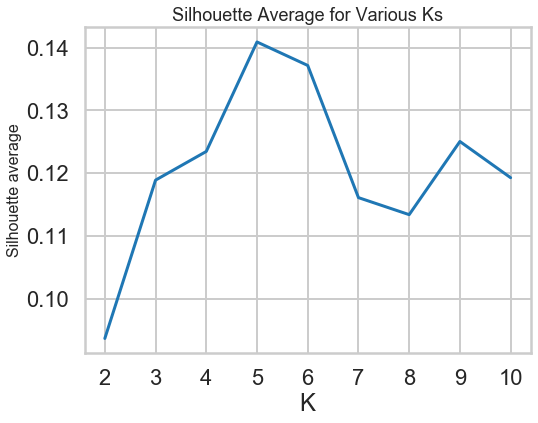

In [19]:
# Plot silhouette averages vs K

fig = plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), sil_avg)
plt.xticks(range(2,11), range(2, 11))
plt.xlabel('K')
plt.ylabel('Silhouette average', fontsize=16)
plt.title('Silhouette Average for Various Ks', fontsize=18);

### Exercise Set III: Answers
Going by average silhouette score, we should choose K = 5. This is consistent with the K obtained from elbow method, which is also K = 5. The highest silhouette score is just 0.141, which suggests that there is no substanital clustering structure found in this data. Furthermore, some points in cluster 3 and 4 have negative silhouette coefficients. 

The thickness of silhouette plots is not of similar size even when K = 5, but I do not think this indicates a problem as there could be clusters of different size even when there is a perfect clustering. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [20]:
# Fit KMeans to get cluster labels
km = KMeans(n_clusters=5, random_state=42)
labels = km.fit_predict(x_cols)

# PCA to get first two principal components
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_cols)
X_pca = pca.transform(x_cols)

# Create a dataframe of customer name, cluster_id and first two principal components
pca_df = pd.DataFrame({'customer_name': df_wide.customer_name,
                       'cluster_id': labels,
                       'first_principal_comp': X_pca[:, 0],
                       'second_principal_comp': X_pca[:, 1]
                       })
# Print a few rows of pca_df
pca_df.sample(10)

,customer_name,cluster_id,first_principal_comp,second_principal_comp
53,Moore,4,-0.239706,0.911844
80,Sanchez,3,-1.077511,-0.229397
25,Foster,3,-0.782355,-0.518475
96,Wilson,1,0.688224,-0.013688
46,Lewis,1,1.031897,-0.138928
13,Clark,0,-0.579221,-0.420475
29,Gray,4,-0.330960,0.607623
10,Butler,2,-0.240431,-0.617026
21,Edwards,1,0.181048,-0.020653
64,Perry,1,1.340000,-0.008172


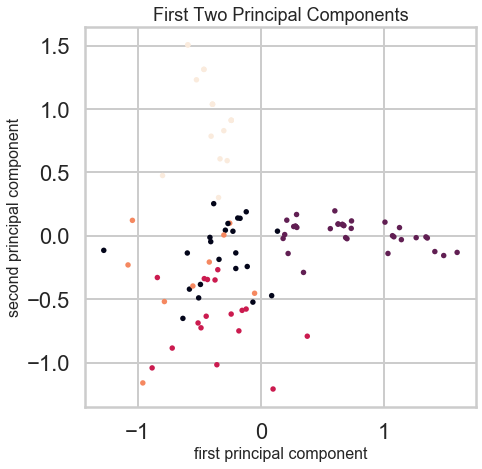

In [21]:
# Plot first two principal components
plt.figure(figsize=(7,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], linewidths=0, s=30,c=labels)
plt.xlabel("first principal component", fontsize=16)
plt.ylabel("second principal component", fontsize=16)
plt.title("First Two Principal Components", fontsize=18);

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [22]:
# Add cluster label to wide_df dataframe
df_wide['cluster_id'] = labels
df_wide_sorted = df_wide.sort_values('cluster_id')
df_wide_sorted.to_csv('cluster_df.csv', index=False)


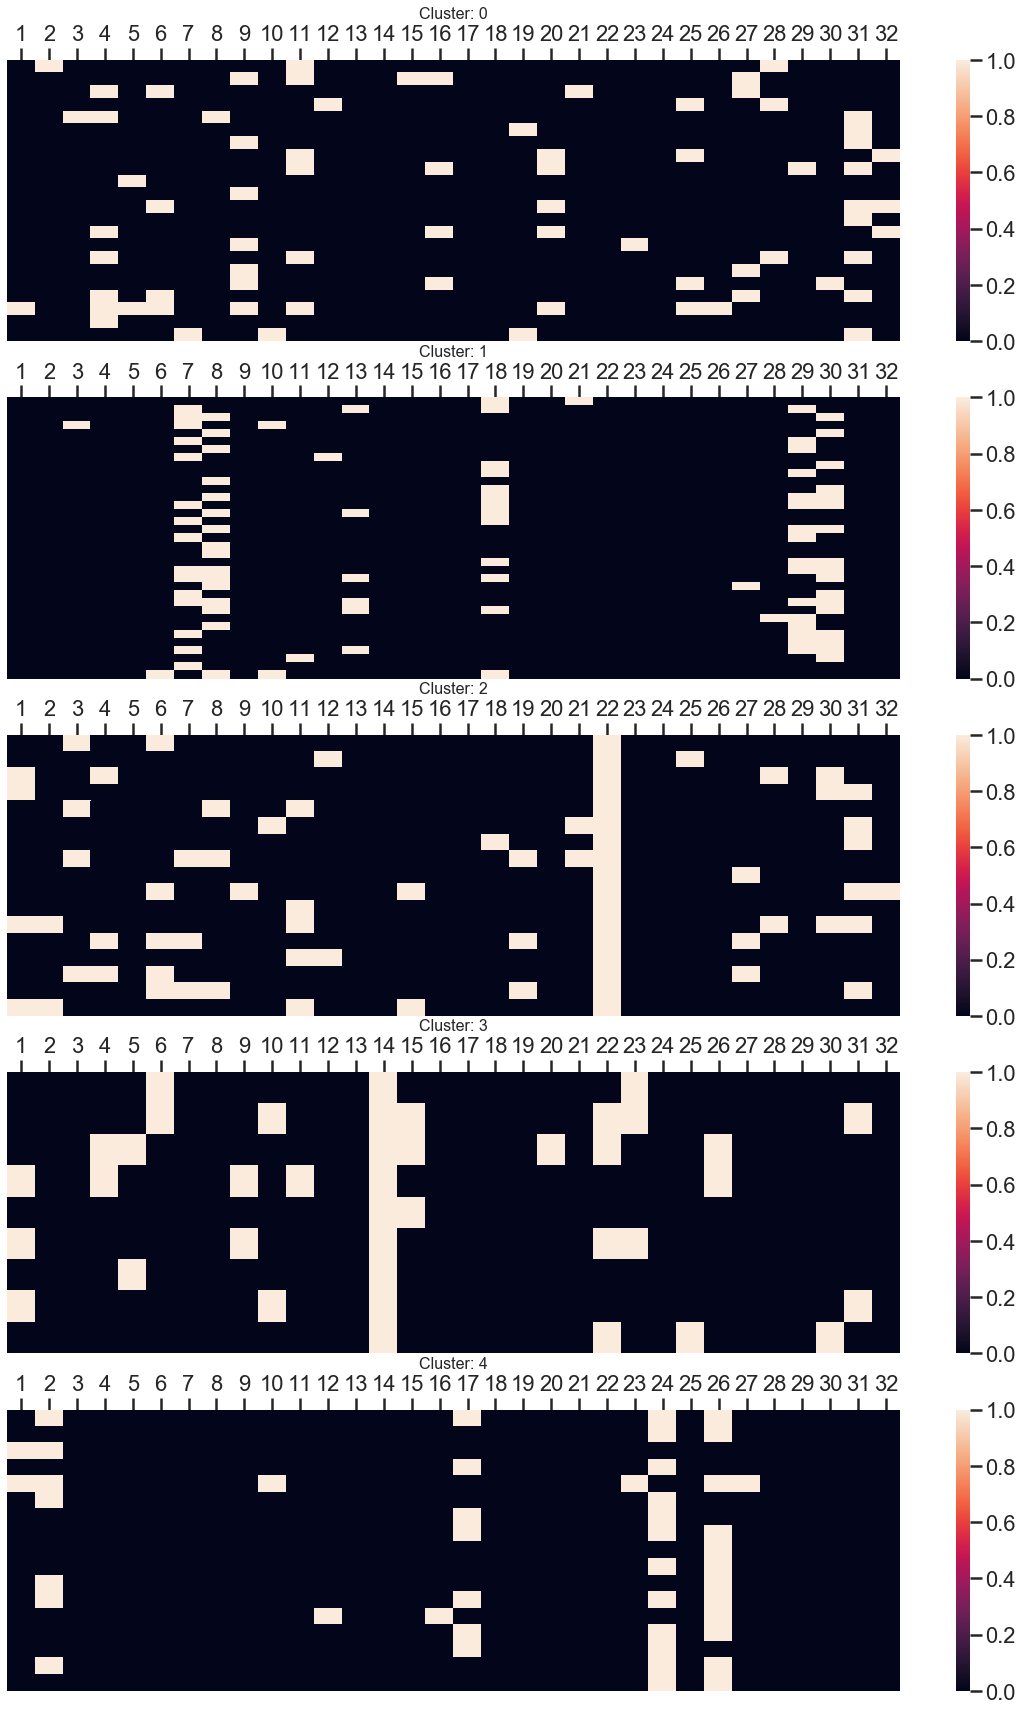

In [23]:
# Create a heat-map of data belonging to each cluster to see if there is any pattern that 
# diferentiate clusters.
fig = plt.figure(figsize=(20,30))
for i in range(5):
    ax = fig.add_subplot(5, 1, i+1)
    ax.xaxis.tick_top()
    plt.title(f'Cluster: {i}', fontsize=16)
    sns.heatmap(df_wide_sorted.iloc[:, 1:-1][df_wide_sorted.cluster_id == i], yticklabels=False, ax=ax);
    

In [24]:
# Looking at the above heatmap, pick some of the important features (offers) that might have played 
# a major role in cluster formation
imp_features = {0: [4, 9, 11, 31],
                1: [7, 8, 18, 29, 30],
                2: [22],
                3: [14, 22],
                4: [2, 17, 24, 26]}
imp_features_lst = []
for key in imp_features:
    for i in imp_features[key]:
        imp_features_lst.append(i)
imp_features_lst

[4, 9, 11, 31, 7, 8, 18, 29, 30, 22, 14, 22, 2, 17, 24, 26]

In [25]:
# Print the dataframe of above important features (offers) to see their characteristicks.
df_offers.iloc[imp_features_lst,]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
9,10,April,Prosecco,72,52,California,False
11,12,May,Prosecco,72,83,Australia,False
31,32,December,Cabernet Sauvignon,72,45,Germany,True
7,8,March,Espumante,6,45,South Africa,False
8,9,April,Chardonnay,144,57,Chile,False
18,19,July,Champagne,12,66,Germany,False
29,30,December,Malbec,6,54,France,False
30,31,December,Champagne,72,89,France,False
22,23,September,Chardonnay,144,39,South Africa,False


### Exercise Set IV: Answers
As per PCA scatterplot, clusters are not well separated and there is quite a bit of intemingling among clusters. This is consistent with the low silhouette  coefficient observed with best K = 5. We just have 100 smaples. It looks like either we need more samples to discern the structure or inherently there is no strong pattern. 

Note: it should be noted that both elbow and silhouette method indicated that K = 5 is the best K among the Ks tried.

Do the clusters correspond to wine variants or something else interesting?

In this data, as mentioned above no substantial structure has been found.So it is hard to found correspondence between clusters and a particular feature. Nevertheless, I picked some features that seems to have influenced cluster formation based on the heat map above. I checked these offers to see if there is a variation between clusters with respect to any featres like wine variants, country of origin etc. However, I did not find a pattern as there is a lot variation even within the clusters with respect to these features. Only thing that stood out is the feature 22 seems to have played a major role in the formation of cluster 2 and 3. To this offer only people in cluster 2 and 3 responded. Similarly, to the offer 14, only people in the cluster 3 responded. However, these two offers are not unique with respect to any one feature like wine variant, country of origin, etc.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

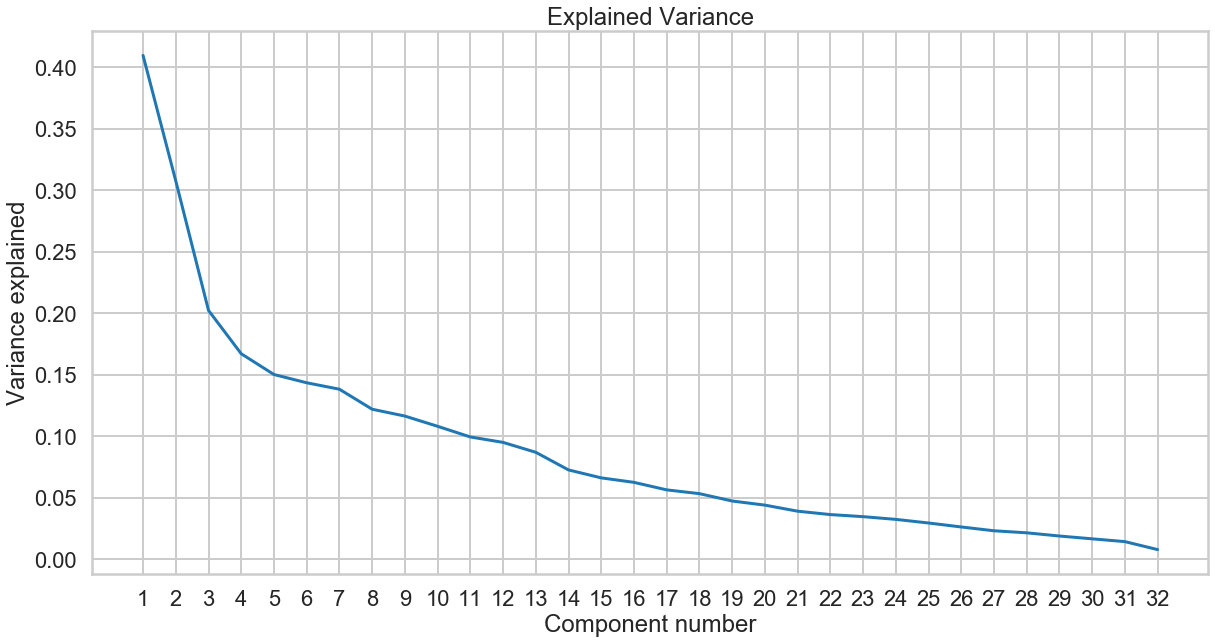

In [26]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

plt.figure(figsize=(20, 10))
plt.plot(pca.explained_variance_);
plt.xticks(range(0,32), range(1,33))
plt.title('Explained Variance')
plt.xlabel('Component number')
plt.ylabel('Variance explained');

### Excercise Set V: Answers
Looking at the above elbow plot, the optimal number of dimensions seem to be 4. However, the elbow point is not very distinct on the above plot.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [27]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, DBSCAN, AgglomerativeClustering


#### Affinity propogation

In [28]:
labels = AffinityPropagation().fit_predict(x_cols)
silhouette_avg = silhouette_score(x_cols, labels)
print(f'Silhouetter average for affinity progation is; {round(silhouette_avg, 2)}')

Silhouetter average for affinity progation is; 0.12


#### Spectral clustering

In [29]:
# Find optimal number of clusters
for i in range(2, 11):
    labels = SpectralClustering(i).fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels)
    print(f'Silhouette average for spectral clustering witn n = {i} is; {round(silhouette_avg, 2)}')

Silhouette average for spectral clustering witn n = 2 is; 0.08
Silhouette average for spectral clustering witn n = 3 is; 0.11
Silhouette average for spectral clustering witn n = 4 is; 0.09
Silhouette average for spectral clustering witn n = 5 is; 0.1
Silhouette average for spectral clustering witn n = 6 is; 0.1
Silhouette average for spectral clustering witn n = 7 is; 0.08
Silhouette average for spectral clustering witn n = 8 is; 0.1
Silhouette average for spectral clustering witn n = 9 is; 0.09
Silhouette average for spectral clustering witn n = 10 is; 0.1


#### Agglomerative clustering

In [30]:
# Find optimal number of clusters
for i in range(2, 11):
    labels = AgglomerativeClustering(i).fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels)
    print(f'Silhouette average for aglomerative clustering witn n = {i} is; {round(silhouette_avg, 2)}')

Silhouette average for aglomerative clustering witn n = 2 is; 0.08
Silhouette average for aglomerative clustering witn n = 3 is; 0.12
Silhouette average for aglomerative clustering witn n = 4 is; 0.13
Silhouette average for aglomerative clustering witn n = 5 is; 0.14
Silhouette average for aglomerative clustering witn n = 6 is; 0.15
Silhouette average for aglomerative clustering witn n = 7 is; 0.15
Silhouette average for aglomerative clustering witn n = 8 is; 0.16
Silhouette average for aglomerative clustering witn n = 9 is; 0.12
Silhouette average for aglomerative clustering witn n = 10 is; 0.1


#### DBSCAN

In [31]:
labels = DBSCAN(eps=2).fit_predict(x_cols)
silhouette_avg = silhouette_score(x_cols, labels)
print(f'Silhouette average for DBSCAN is; {round(silhouette_avg, 2)}')
print('\nPredicted labels:')
labels

Silhouette average for DBSCAN is; 0.23

Predicted labels:


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)

### Comparison of Different Clustering Algorithms

In [32]:
algos = ['KMeans (n = 5)', 'Affinity propagation', 'Spectral clustering (n = 3)',
         'Agglomerative clustering (n = 8)', 'DBSCAN']

sil_avg = [0.14, 0.12, 0.11, 0.16, 0.23]

# Create a dataframe of algorithms tried and their silhouetter averages
pd.DataFrame({'Clustering Algorithms' : algos,
            'Silhouetter Average' : sil_avg})

,Clustering Algorithms,Silhouetter Average
0,KMeans (n = 5),0.14
1,Affinity propagation,0.12
2,Spectral clustering (n = 3),0.11
3,Agglomerative clustering (n = 8),0.16
4,DBSCAN,0.23


## Conclusion

Here I have tried five different algorithms to cluster transactional data of customers who responded to various offers. I could not find a substantial clustering structure in this data. DBSCAN yielded the highest silhouette average among the five algorithms used. However, it should be noted that it grouped all the data into one cluster, and identifed three customers as outliers. So this kind of clustering may not be useful at all. If I reduce the episolon, it would identify all the datapoints as outliers. This is consistent with the fact that the data is very spread out as can be seen on PCA plot above. Among the other four algorithms, agglomerative clustering produced the highest silhouette average of 0.16.

In conclusion, either we need more samples to discern the structure. It is also possible that there is no inherent structure among different customers as to how they respond to various offers. 